In [1]:
import pickle

with open('xray_data.pickle', 'rb') as f:
   (train_images, test_images, train_labels, test_labels, val_images, val_labels) = pickle.load(f)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from sklearn.preprocessing import LabelEncoder

In [3]:
def prepare_train_data(images, labels):
    # Balance classes
    from imblearn.over_sampling import SMOTE
    smote=SMOTE()
    images_flattened = images.reshape(images.shape[0], -1)
    images_resampled, labels_resampled = smote.fit_resample(images_flattened, labels)
    images_resampled = images_resampled.reshape(-1, images.shape[1], images.shape[2], images.shape[3])
    # Shuffle
    from sklearn.utils import shuffle
    images_shuffled, labels_shuffled = shuffle(images_resampled, labels_resampled, random_state=42)
    # Normalize
    X = images_shuffled/255.0
    # Encode
    encode = LabelEncoder()
    y = encode.fit_transform(labels_shuffled)

    return X, y

In [4]:
def prepare_test_data(images, labels):
    X = images/255.0
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)
    return X, y
 

In [5]:
X_train, y_train = prepare_train_data(train_images, train_labels)

In [6]:
X_val, y_val  = prepare_test_data(val_images, val_labels)
X_test, y_test = prepare_test_data(test_images, test_labels)

In [7]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense,Input,Conv2D,Flatten,MaxPool2D,Dropout

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [8]:
model = create_cnn_model(input_shape = train_images[0].shape)

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 64)        1

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=3)

In [11]:
hist = model.fit(X_train, y_train, epochs=15, validation_split=0.1, callbacks=[early_stopping_monitor])

Epoch 1/15
218/218 [==============================] - 28s 125ms/step - loss: 0.3138 - accuracy: 0.8579 - val_loss: 0.1894 - val_accuracy: 0.9174
Epoch 2/15
218/218 [==============================] - 26s 119ms/step - loss: 0.1112 - accuracy: 0.9593 - val_loss: 0.0899 - val_accuracy: 0.9639
Epoch 3/15
218/218 [==============================] - 26s 119ms/step - loss: 0.0800 - accuracy: 0.9706 - val_loss: 0.1059 - val_accuracy: 0.9626
Epoch 4/15
218/218 [==============================] - 27s 122ms/step - loss: 0.0604 - accuracy: 0.9769 - val_loss: 0.0803 - val_accuracy: 0.9755
Epoch 5/15
218/218 [==============================] - 26s 119ms/step - loss: 0.0532 - accuracy: 0.9808 - val_loss: 0.0627 - val_accuracy: 0.9755
Epoch 6/15
218/218 [==============================] - 26s 120ms/step - loss: 0.0372 - accuracy: 0.9861 - val_loss: 0.0730 - val_accuracy: 0.9794
Epoch 7/15
218/218 [==============================] - 26s 119ms/step - loss: 0.0335 - accuracy: 0.9864 - val_loss: 0.0532 - val_ac

Eval training performance

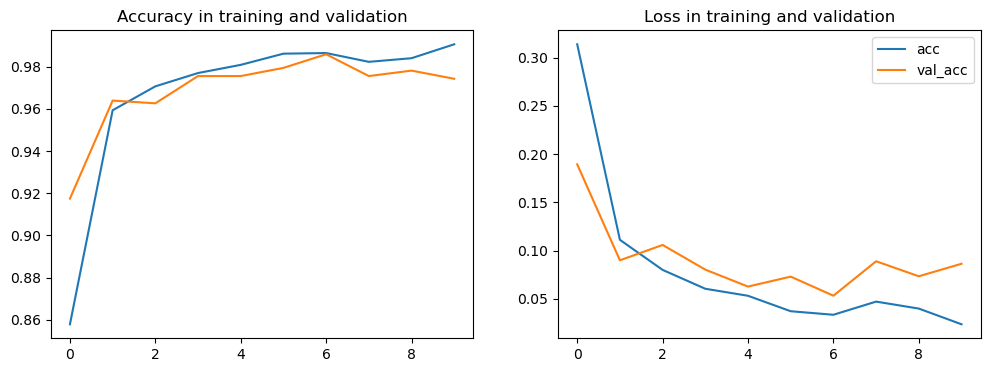

In [12]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc)) 

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,4))

# plot accuracy with matplotlib
ax1.plot(epochs, acc)
ax1.plot(epochs, val_acc)
ax1.set_title('Accuracy in training and validation')


# plot loss with matplotlib
ax2.plot(epochs, loss)
ax2.plot(epochs, val_loss)
ax2.set_title('Loss in training and validation')

plt.legend(['acc', 'val_acc'])
plt.show()

Determine the best threshold to limit FP (misdiagnosing) and FN (missing the diagnosis).

In [13]:
from sklearn.metrics import f1_score

# Get prediction probabilities for class 1 (Pneumonia)
y_pred_prob = model.predict(X_test)  
y_test_binary = y_test.astype(bool)  # Convert true labels to binary (True for Pneumonia, False for Normal))

# Create a list of thresholds to evaluate (between 0 and 1)
thresholds = np.linspace(0, 1, 100)

# Find the threshold that maximizes the F1-score (minimizes the combination of FPs and FNs)
best_f1_score = 0.0
best_threshold = None

for threshold in thresholds:
    y_pred_class = (y_pred_prob >= threshold).astype(bool)
    f1 = f1_score(y_test_binary, y_pred_class)
  
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

# Print the best results
print("Best F1-score:", best_f1_score)
print("Best Threshold:", best_threshold)

20/20 [==============================] - 1s 27ms/step
Best F1-score: 0.8806488991888761
Best Threshold: 0.98989898989899


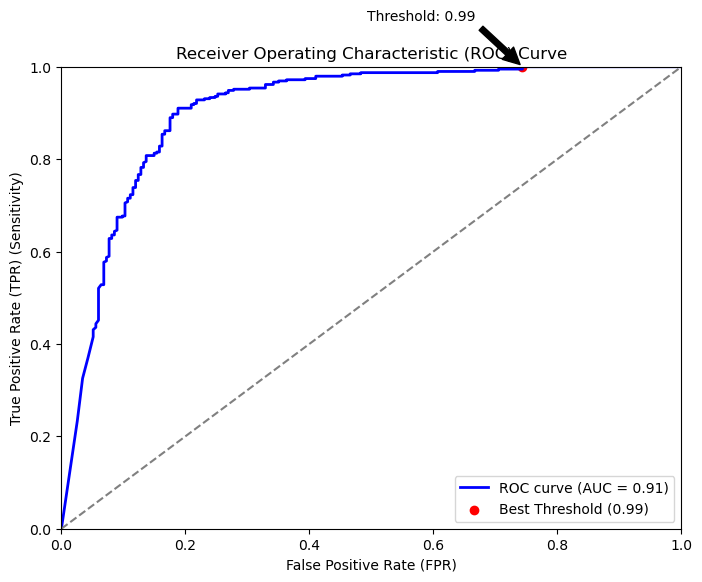

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_class = (y_pred_prob >= best_threshold).astype(bool)
y_pred = np.rint(y_pred_prob)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Mark the best threshold on the ROC curve plot
plt.scatter(fpr[np.argmax(tpr - (1 - tpr) * f1)], tpr[np.argmax(tpr - (1 - tpr) * best_f1_score)], color='red', label=f'Best Threshold ({best_threshold:.2f})')
plt.annotate(f'Threshold: {best_threshold:.2f}', xy=(fpr[np.argmax(tpr - (1 - tpr) * best_f1_score)], tpr[np.argmax(tpr - (1 - tpr) * best_f1_score)]),
             xytext=(fpr[np.argmax(tpr - (1 - tpr) * best_f1_score)] - 0.25, tpr[np.argmax(tpr - (1 - tpr) * best_f1_score)] + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
)

plt.legend(loc="lower right")
plt.show()

Confusion matrix for best threshold

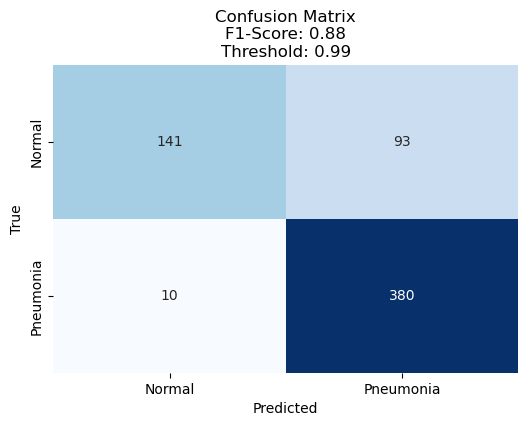

In [15]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_class)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"Confusion Matrix\nF1-Score: {best_f1_score:.2f}\nThreshold: {best_threshold:.2f}")
plt.xticks([0.5, 1.5], ['Normal', 'Pneumonia'])
plt.yticks([0.5, 1.5], ['Normal', 'Pneumonia'])
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

acc = accuracy_score(y_test, np.rint(y_pred_prob))
prec = precision_score(y_test, np.rint(y_pred_prob))
rec = recall_score(y_test, np.rint(y_pred_prob))
f = f1_score(y_test, np.rint(y_pred_prob))
conf = confusion_matrix(y_test, np.rint(y_pred_prob))

print("Initial Accuracy:", acc)
print("Initial Precision:", prec)
print("Initial Recall:", rec)
print("Initial F1-score:", f)
print("Initial Confusion Matrix:\n", conf)

Initial Accuracy: 0.7259615384615384
Initial Precision: 0.696588868940754
Initial Recall: 0.9948717948717949
Initial F1-score: 0.8194297782470961
Initial Confusion Matrix:
 [[ 65 169]
 [  2 388]]


The model predictions have a high recall at the benefit of precision. 

With a threshold increase from 0.5 to 0.99,  we are able prevent 76 incorrect diagnoses but at the cost of 8 missed ones. This is the best threshold to balance the precision and recall of this model.

In [17]:
accuracy = accuracy_score(y_test_binary, y_pred_class)
precision = precision_score(y_test_binary, y_pred_class)
recall = recall_score(y_test_binary, y_pred_class)
f1 = f1_score(y_test_binary, y_pred_class)
confusion = confusion_matrix(y_test_binary, y_pred_class)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.8349358974358975
Precision: 0.8033826638477801
Recall: 0.9743589743589743
F1-score: 0.8806488991888761
Confusion Matrix:
 [[141  93]
 [ 10 380]]
